In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/processed/labelled_data.csv')

In [3]:
df.head()

,helpfulVotes,id,address,city,placeName,numberOfReviews,placeRating,webUrl,publishedDate,userRating,...,rule_based_tokens,spacy_tokens,wordpiece_tokens,vader_score,compound_score,vader_category,flair_sentiment,flair_confidence,textblob_sentiment,ground_truth
0,0.0,978474125.0,"24 Dharmapala Mawatha Dharmapala Mawatha, Colo...",Colombo,Nh Collection Colombo,2392,4.5,https://www.tripadvisor.com/Hotel_Review-g2939...,2024-11-03,5.0,...,"['good', 'service', 'ayu', 'friendly', 'staff'...","['good', 'service', 'ayu', 'friendly', 'staff'...","['good', 'service', 'ayu', 'friendly', 'staff'...","{'neg': 0.0, 'neu': 0.389, 'pos': 0.611, 'comp...",0.9868,positive,positive,0.943697,positive,positive
1,0.0,978053018.0,"24 Dharmapala Mawatha Dharmapala Mawatha, Colo...",Colombo,Nh Collection Colombo,2392,4.5,https://www.tripadvisor.com/Hotel_Review-g2939...,2024-10-30,1.0,...,"['change', 'r', 'lady', 'manager', 'r', 'hotel...","['change', 'r', 'lady', 'manager', 'r', 'hotel...","['change', 'r', 'lady', 'manager', 'r', 'hotel...","{'neg': 0.173, 'neu': 0.762, 'pos': 0.066, 'co...",-0.3990,negative,positive,0.590723,negative,negative
2,0.0,976992067.0,"24 Dharmapala Mawatha Dharmapala Mawatha, Colo...",Colombo,Nh Collection Colombo,2392,4.5,https://www.tripadvisor.com/Hotel_Review-g2939...,2024-10-28,5.0,...,"['perfect', 'liked', 'everything', 'staff', 'k...","['perfect', 'liked', 'everything', 'staff', 'k...","['perfect', 'liked', 'everything', 'staff', 'k...","{'neg': 0.079, 'neu': 0.334, 'pos': 0.587, 'co...",0.9796,positive,positive,0.922921,positive,positive
3,0.0,976690540.0,"24 Dharmapala Mawatha Dharmapala Mawatha, Colo...",Colombo,Nh Collection Colombo,2392,4.5,https://www.tripadvisor.com/Hotel_Review-g2939...,2024-10-26,5.0,...,"['stay', 'unforgettable', 'hotel', 'beautiful'...","['stay', 'unforgettable', 'hotel', 'beautiful'...","['stay', 'unforgettable', 'hotel', 'beautiful'...","{'neg': 0.0, 'neu': 0.68, 'pos': 0.32, 'compou...",0.9468,positive,positive,0.996439,positive,positive
4,0.0,976664122.0,"24 Dharmapala Mawatha Dharmapala Mawatha, Colo...",Colombo,Nh Collection Colombo,2392,4.5,https://www.tripadvisor.com/Hotel_Review-g2939...,2024-10-26,5.0,...,"['amazing', 'hotel', 'well', 'situated', 'colo...","['amazing', 'hotel', 'well', 'situated', 'colo...","['amazing', 'hotel', 'well', 'situated', 'colo...","{'neg': 0.024, 'neu': 0.522, 'pos': 0.455, 'co...",0.9961,positive,positive,0.991161,positive,positive


## Vectorizing text data

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, ngram_range=(1,1))
X_counts = count_vectorizer.fit_transform(df['spacy_tokens'])

feature_names = count_vectorizer.get_feature_names_out()

print(f'Count Vectorizer Feature Matrix Shape: {X_counts.shape}')  # (Number of Reviews, Number of Features)

Count Vectorizer Feature Matrix Shape: (11808, 5539)


## Determining Optimal Number of Topics

Using coherence score, which measure the degree of semantic similarity between high scoring words in a topic

In [5]:
import gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.decomposition import LatentDirichletAllocation

# Tokenize the cleaned reviews
tokenized_reviews = [doc.split() for doc in df['review_text']]
# tokenized_reviews = [doc.split() for doc in df['spacy_tokens']]

# Create a Gensim dictionary and corpus
dictionary = Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

# Define the range for the number of topics
topic_range = range(5, 21, 1)  # 5 to 20 topics
coherence_scores = []

for k in topic_range:
    lda = LatentDirichletAllocation(n_components=k, random_state=42, learning_method='batch')
    lda.fit(X_counts)
    
    # Extract topics
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[:-11:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics.append(top_features)
    
    # Compute coherence score
    coherence_model = CoherenceModel(topics=topics, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)
    
    print(f'Number of Topics: {k}, Coherence Score: {coherence:.4f}')


Number of Topics: 5, Coherence Score: 0.4288
Number of Topics: 6, Coherence Score: 0.4444
Number of Topics: 7, Coherence Score: 0.4442
Number of Topics: 8, Coherence Score: 0.4337
Number of Topics: 9, Coherence Score: 0.4485
Number of Topics: 10, Coherence Score: 0.4408
Number of Topics: 11, Coherence Score: 0.4352
Number of Topics: 12, Coherence Score: 0.4453
Number of Topics: 13, Coherence Score: 0.4439
Number of Topics: 14, Coherence Score: 0.4430
Number of Topics: 15, Coherence Score: 0.4525
Number of Topics: 16, Coherence Score: 0.4556
Number of Topics: 17, Coherence Score: 0.4466
Number of Topics: 18, Coherence Score: 0.4395
Number of Topics: 19, Coherence Score: 0.4435
Number of Topics: 20, Coherence Score: 0.4413


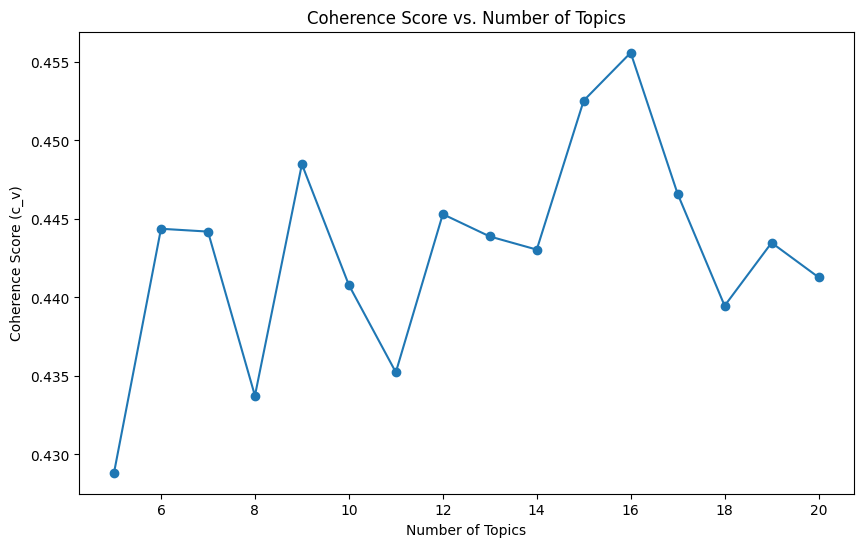

Optimal number of topics based on coherence score: 16


In [6]:

# Plot coherence scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.title('Coherence Score vs. Number of Topics')
plt.show()

# Select the number of topics with the highest coherence score
optimal_k = topic_range[coherence_scores.index(max(coherence_scores))]
print(f'Optimal number of topics based on coherence score: {optimal_k}')


## Applying LDA topic modelling

In [7]:
# Initialize LDA with optimal number of topics
lda_optimal = LatentDirichletAllocation(n_components=optimal_k, random_state=42, learning_method='batch')

# Fit the model
lda_optimal.fit(X_counts)


LatentDirichletAllocation(n_components=16, random_state=42)

In [8]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx +1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")

no_top_words = 10
display_topics(lda_optimal, feature_names, no_top_words)

Topic 1:
hotel, room, one, two, staff, four, five, service, thousand, day


Topic 2:
place, food, staff, amazing, best, stay, service, hotel, room, friendly


Topic 3:
ella, view, room, breakfast, tuk, walk, town, great, train, clean


Topic 4:
stay, staff, hotel, perfect, galle, room, fort, highly, recommend, view


Topic 5:
room, hotel, night, breakfast, would, one, staff, sri, food, two


Topic 6:
hotel, room, staff, good, view, nice, food, clean, friendly, great


Topic 7:
beach, clean, room, place, nice, good, great, stay, staff, friendly


Topic 8:
place, room, nice, good, really, stay, breakfast, family, night, tuk


Topic 9:
kandy, hotel, view, night, room, sri, stayed, pool, one, lanka


Topic 10:
room, hotel, bed, bathroom, water, one, good, night, shower, two


Topic 11:
place, booking, one, hotel, even, like, day, stay, time, booked


Topic 12:
pool, beach, room, view, stay, ocean, staff, breakfast, hotel, made


Topic 13:
great, hotel, food, good, staff, pool, friendly, be

## Visualizing Topics & their Keywords

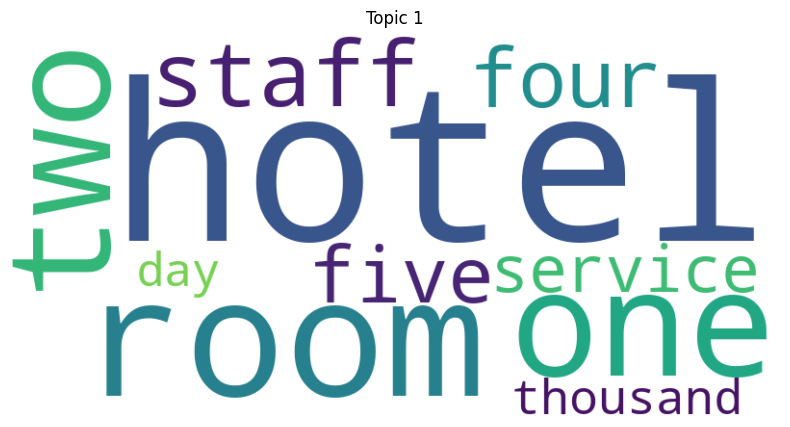

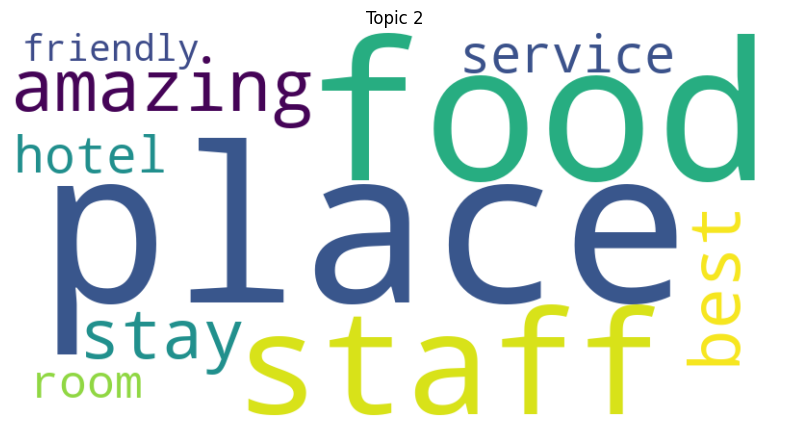

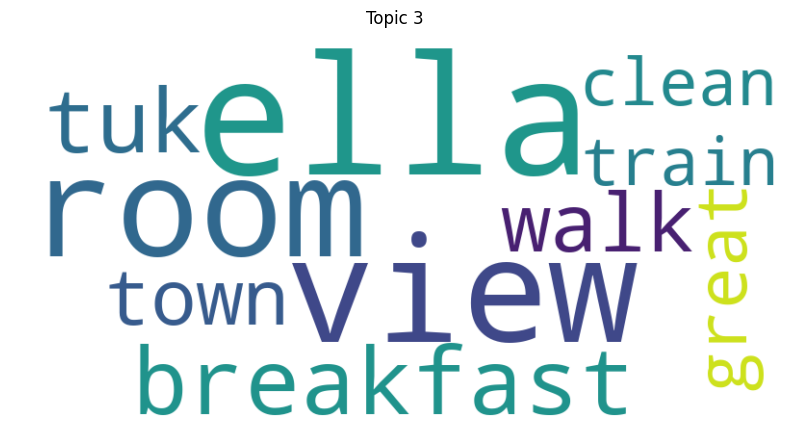

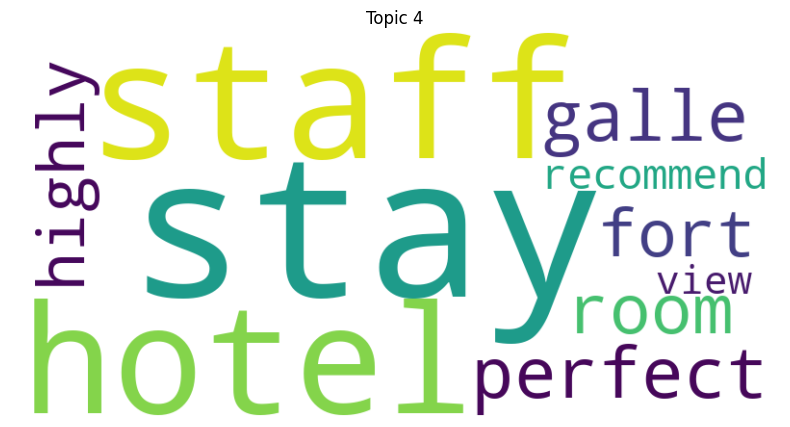

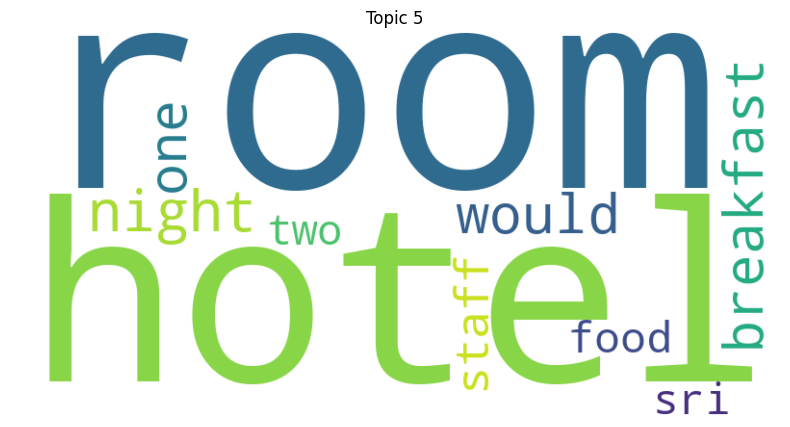

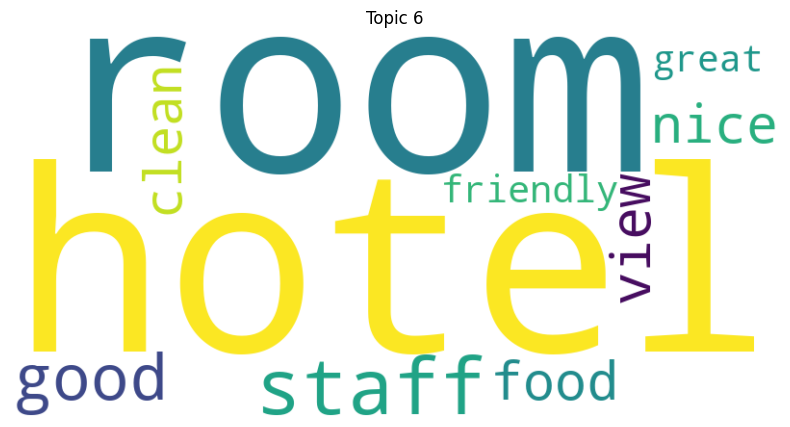

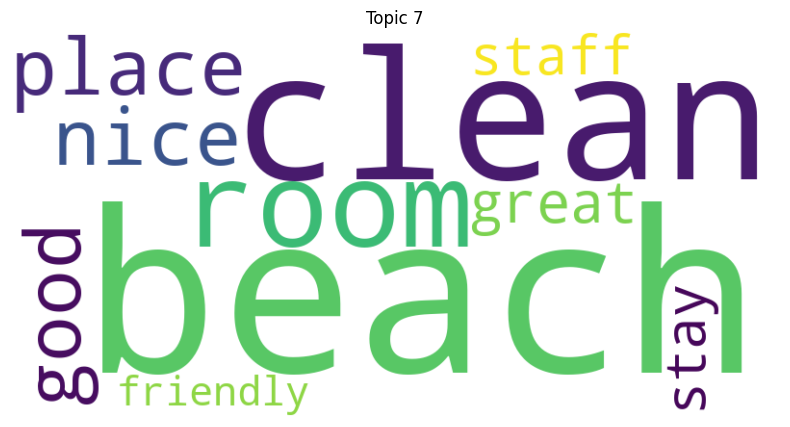

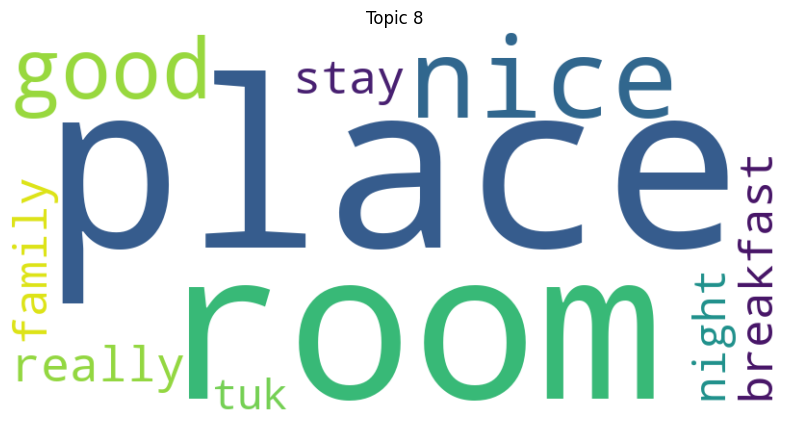

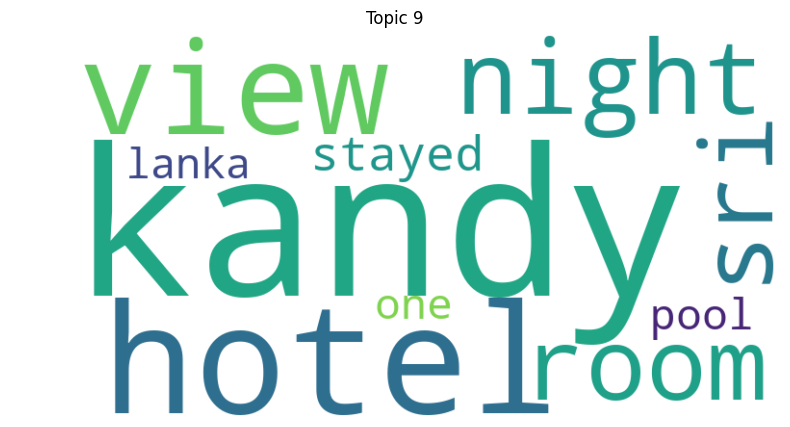

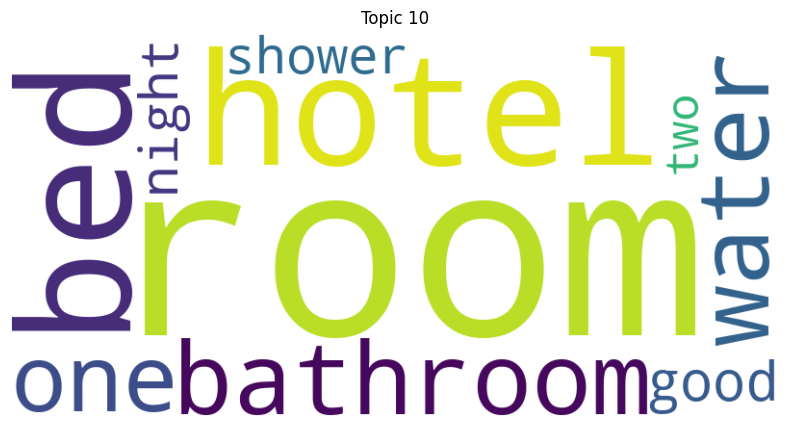

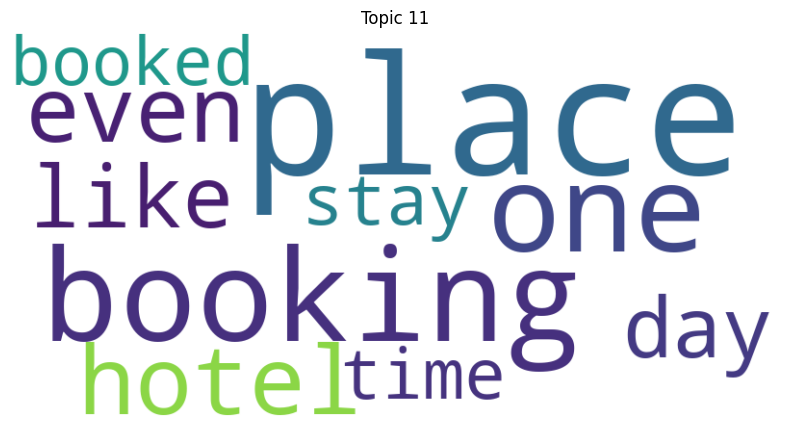

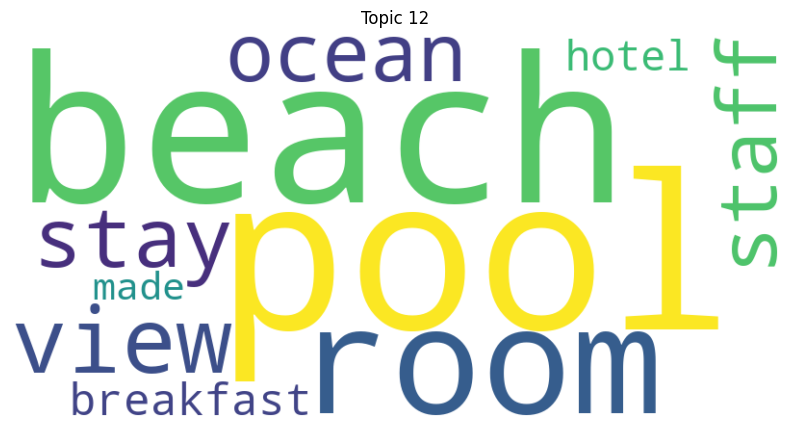

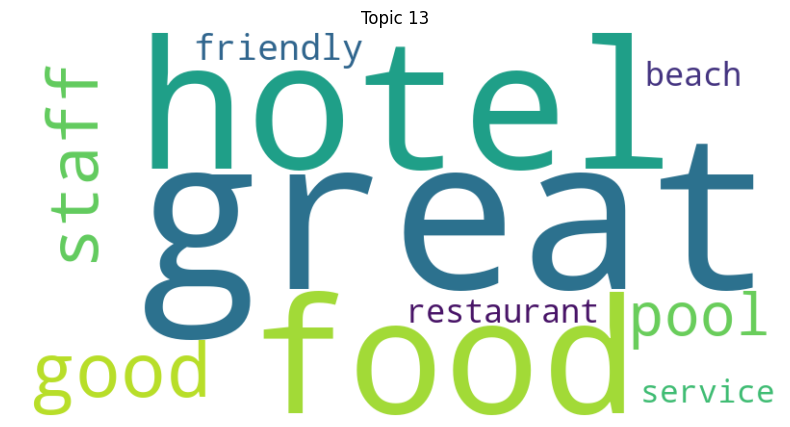

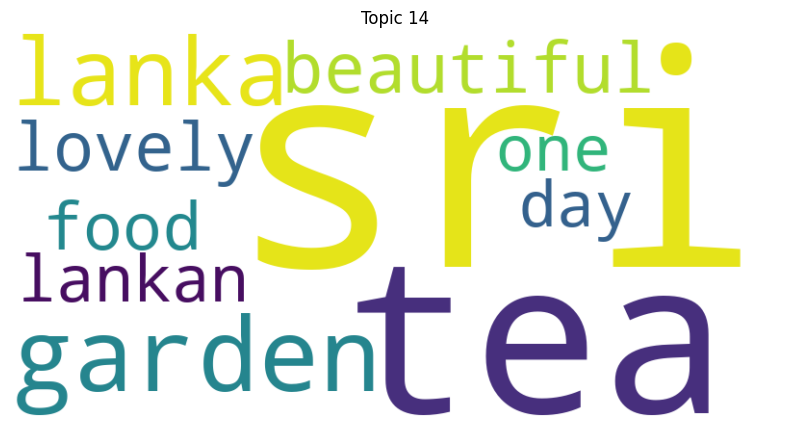

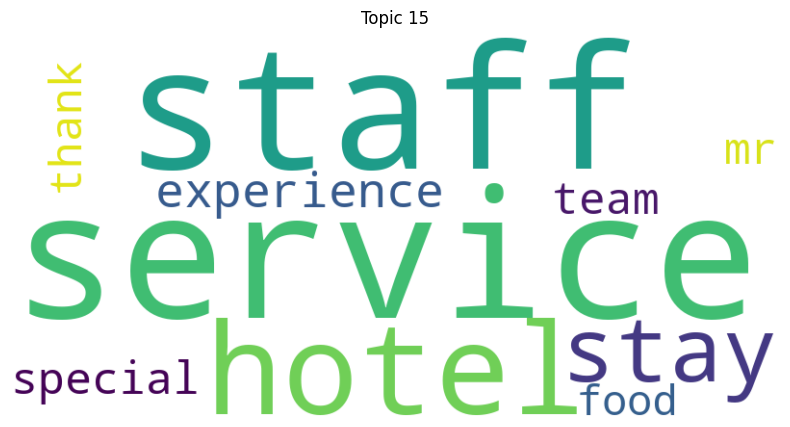

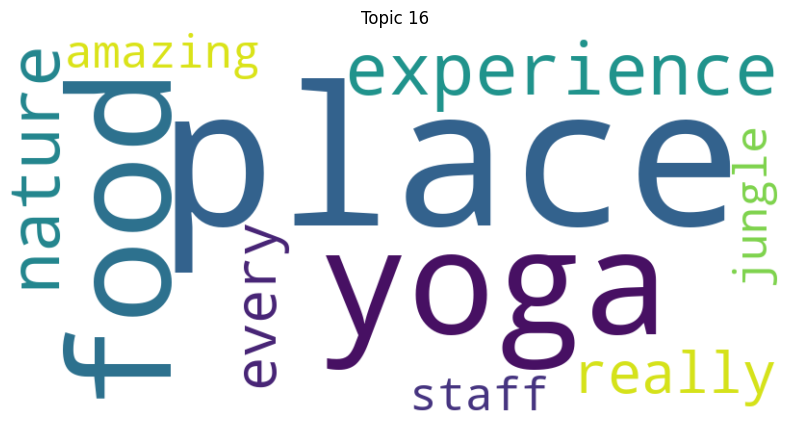

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordclouds(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]
        top_weights = topic[topic.argsort()[:-no_top_words -1:-1]]
        word_freq = dict(zip(top_features, top_weights))
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        
        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic_idx +1}")
        plt.show()

plot_wordclouds(lda_optimal, feature_names, no_top_words)

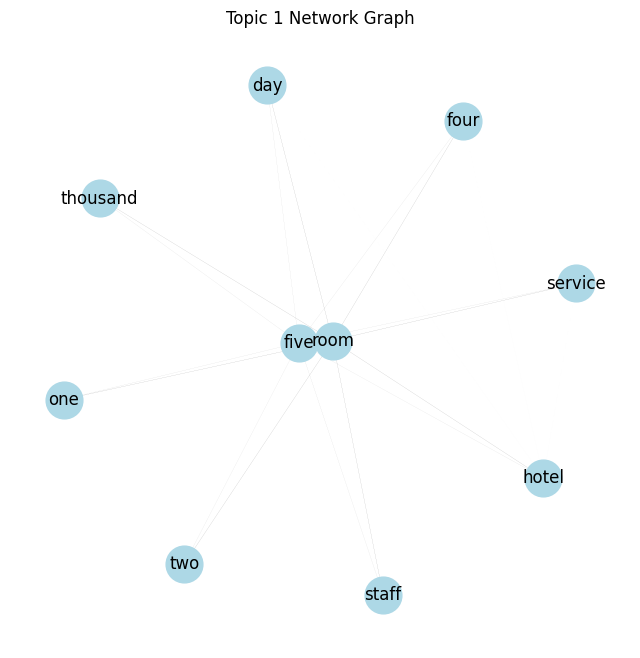

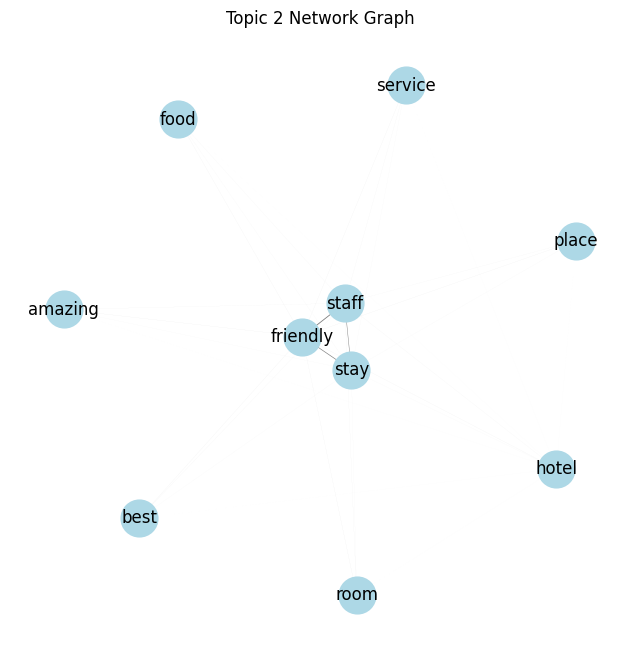

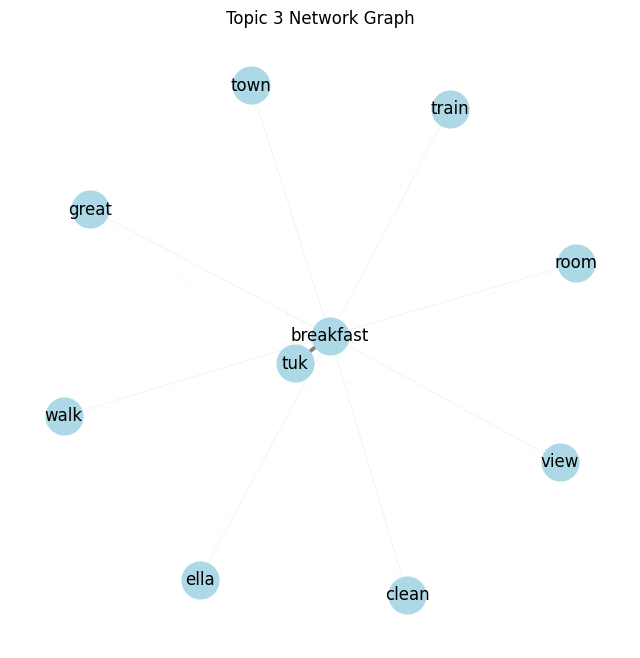

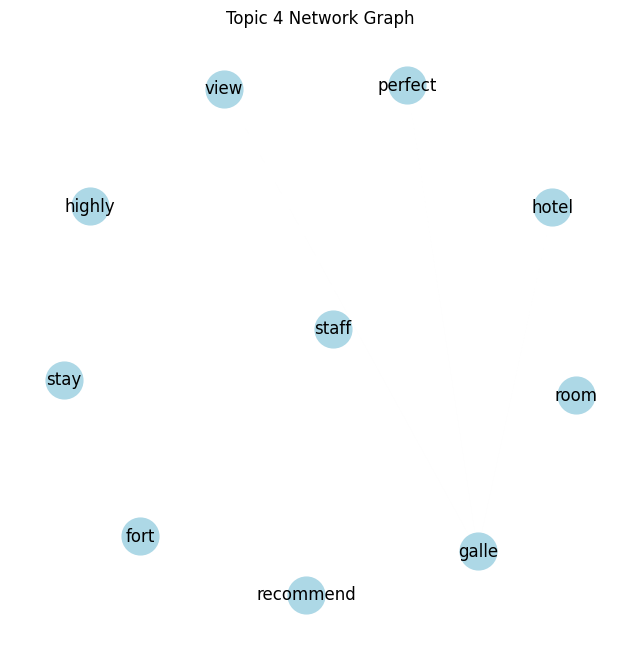

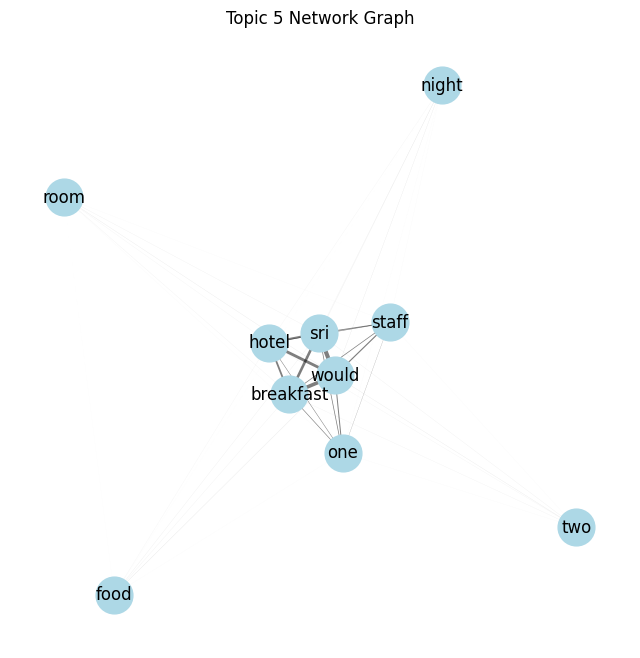

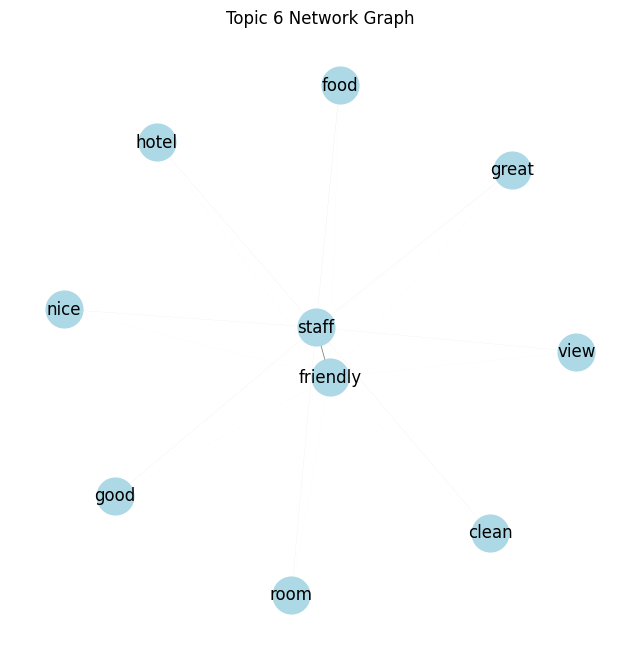

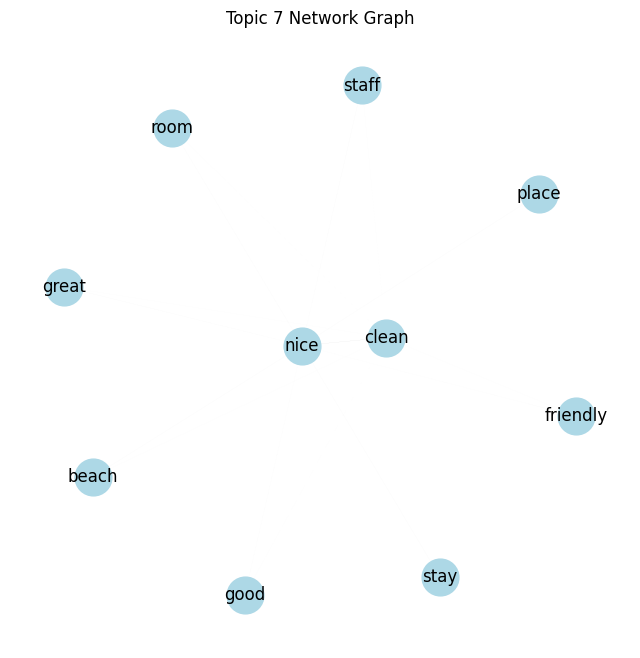

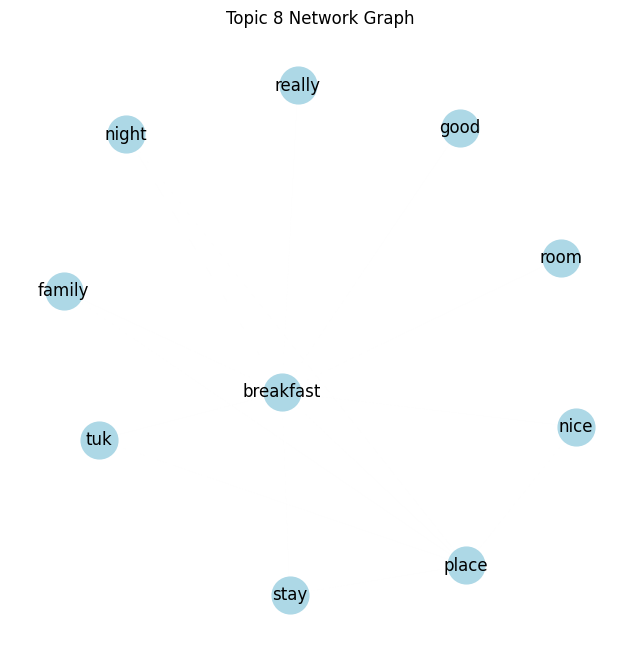

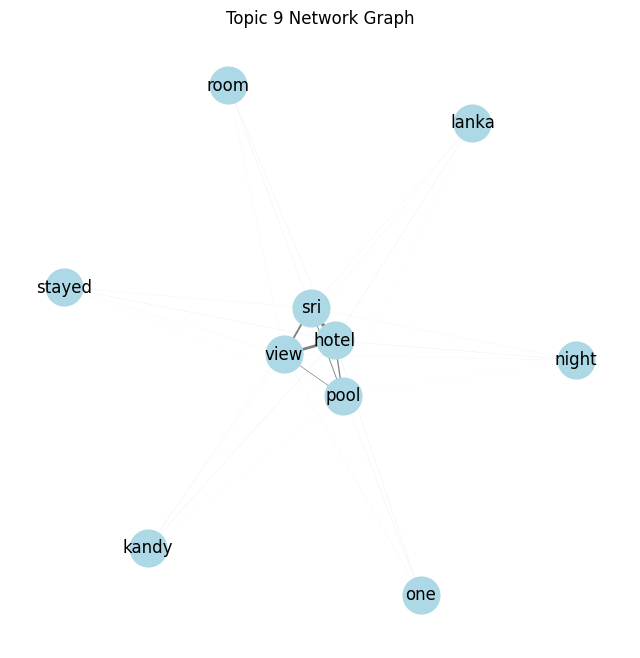

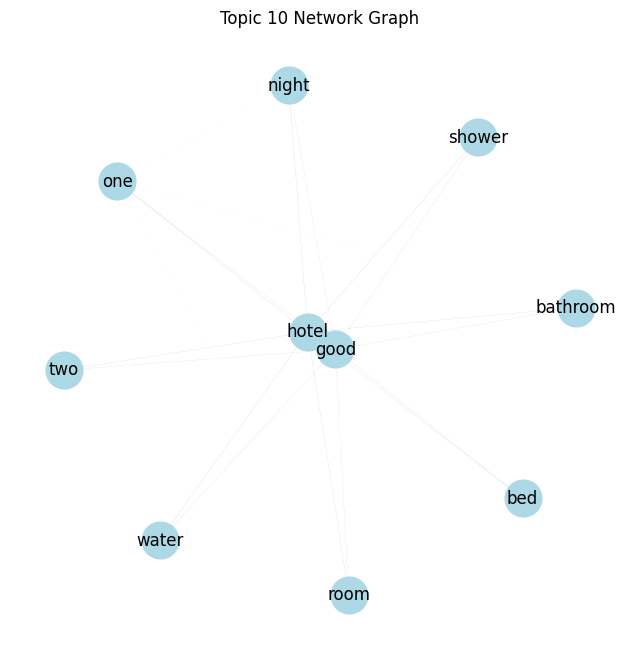

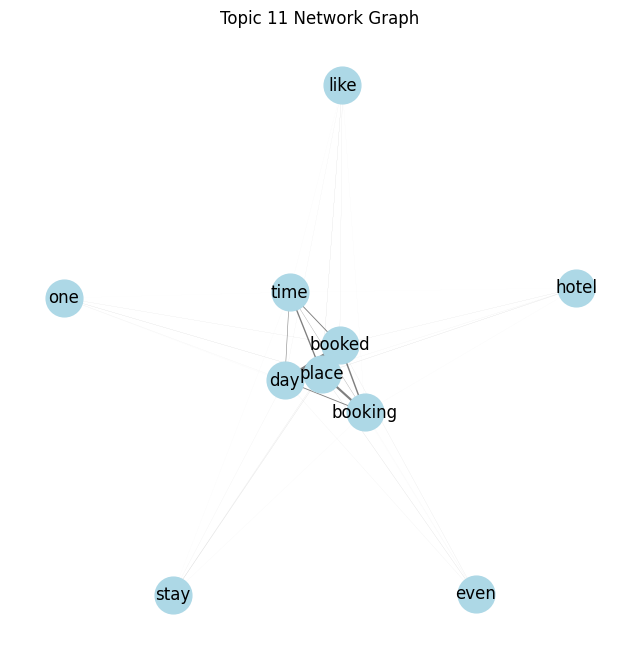

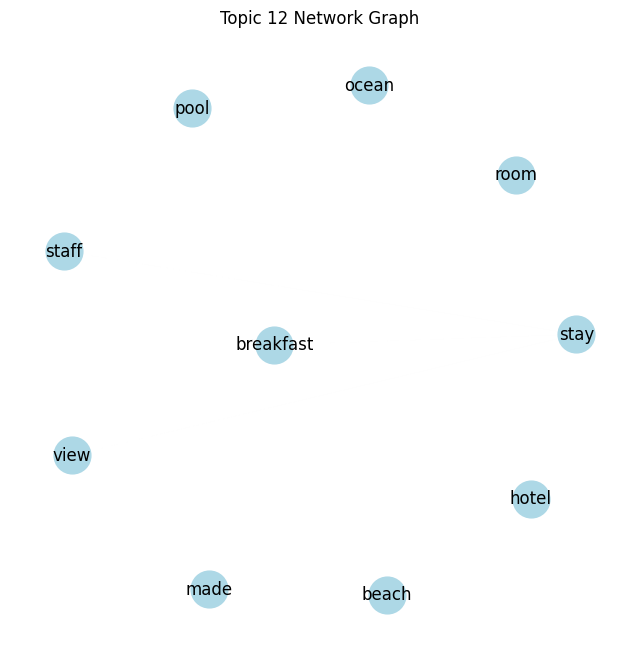

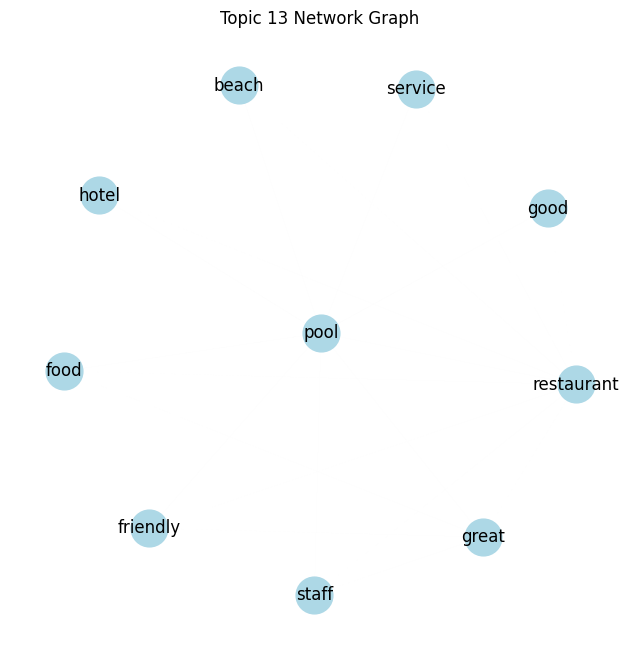

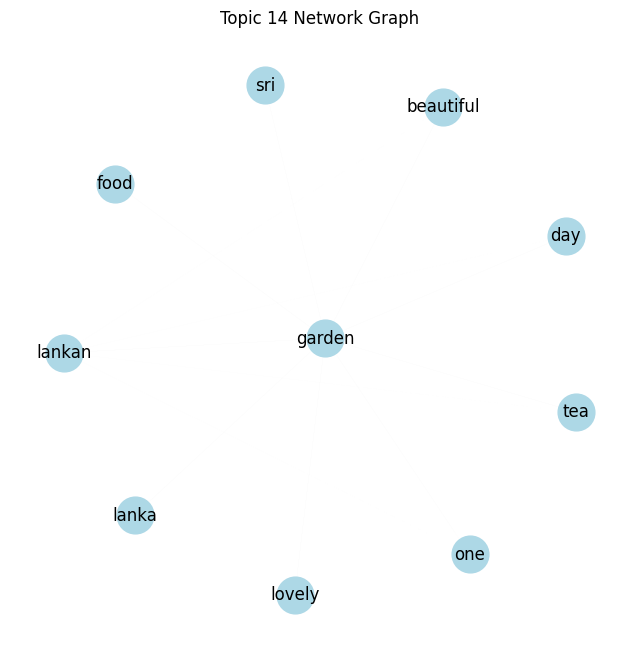

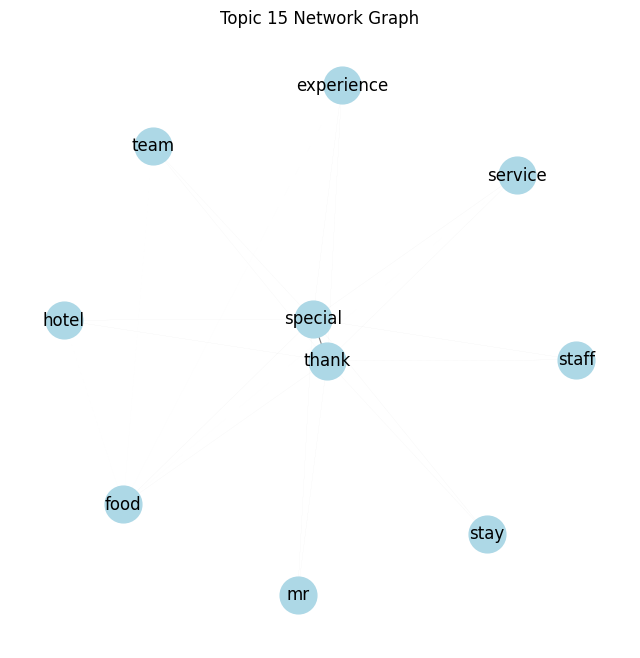

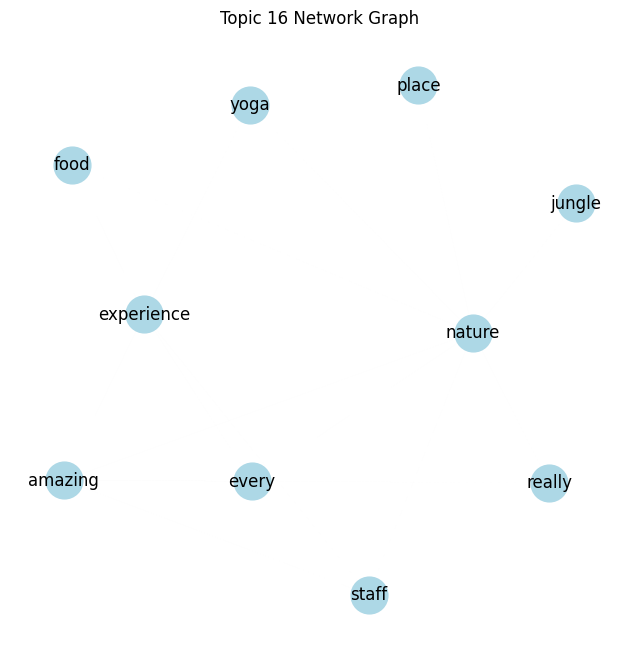

In [10]:
import networkx as nx

def plot_network_graphs(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]
        G = nx.Graph()
        
        # Add nodes
        for word in top_features:
            G.add_node(word)
        
        # Add edges based on co-occurrence in top words
        for i in range(len(top_features)):
            for j in range(i+1, len(top_features)):
                G.add_edge(top_features[i], top_features[j], weight=topic[i]*topic[j])
        
        plt.figure(figsize=(8,8))
        pos = nx.spring_layout(G, k=0.5)
        edges = G.edges(data=True)
        weights = [edge[2]['weight'] for edge in edges]
        
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
        nx.draw_networkx_edges(G, pos, width=[w * 0.1 for w in weights], alpha=0.5)
        nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
        
        plt.title(f"Topic {topic_idx +1} Network Graph")
        plt.axis('off')
        plt.show()

plot_network_graphs(lda_optimal, feature_names, no_top_words)


## Validation of the Topic Modelling

In [13]:
import random

random.seed(42)
subset_reviews = df.sample(n=50, random_state=42).reset_index(drop=True)

In [17]:
manual_labels = []
for review in subset_reviews['review_text']:
    print(review)
    manual_label = input("Enter topic label: ")
    manual_labels.append(manual_label)

subset_reviews['manual_label'] = manual_labels
subset_reviews.head()

best hotel visited free time good hospitality good ambiance nice view room good working room heater ancient breakfast clean tidy friendly staff close kandy city strongly recommend
stayed six night lived like prince boutique hotel virtually place food fantastic pool alone spacious well appointed room outdoor spa host umesh quiet gracious helped u book day trip sigiriya local transport also came chocolate ice cream dessert day day contact breakfast dinner beer local advice danushka mahesh give man pay rise service excellent
arrived two little kid warmly welcomed cabana food great recommend place especially active one sea rough matter anyway pool definitely perfect spot surfing
great location charming setting created middle everything cute log cabin make feel like early settler billards table tea great early evening break dinner staff great went way make sure happy
want super relaxing place stay choose hotel flower garden unawatuna stayed cabana fully equipped mosquito net fridge water to

KeyboardInterrupt: Interrupted by user